In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from scipy.stats import f_oneway, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
import numpy as np

In [ ]:

# Load the uploaded file
file_name = '/content/drive/MyDrive/MCM_data/data_train.xlsx'
df = pd.read_excel(file_name)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Đảm bảo 'df' đã được định nghĩa trước đó

# Kiểm tra và chuyển đổi các cột
df['Year'] = df['Year'].astype(int)  # Chuyển cột 'Year' sang kiểu số nguyên
df['Continent'] = df['Continent'].astype(str)  # Đảm bảo 'Continent' là kiểu chuỗi
df['Is_Host'] = df['Is_Host'].astype(int)  # Chuyển đổi 'Is_Host' sang kiểu số nguyên

# Kiểm tra giá trị nhỏ nhất trong cột 'Distance_To_Host'
min_value = df['Distance_To_Host'].min()

# Nếu có giá trị âm hoặc 0, dịch dữ liệu lên một hằng số dương
if min_value <= 0:
    offset = abs(min_value) + 1  # Thêm hằng số để đảm bảo tất cả giá trị > 0
    df['Distance_To_Host'] = df['Distance_To_Host'] + offset

# Áp dụng Log Transformation
df['Distance_To_Host_Log'] = np.log1p(df['Distance_To_Host'])  # log(x + 1)

# Xóa cột 'Distance_To_Host' gốc
df = df.drop(columns=['Distance_To_Host'])

# Áp dụng OneHotEncoder cho cột 'Continent'
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['Continent','NOC']])  # Mã hóa 'Continent'

# Tạo DataFrame từ dữ liệu mã hóa
encoded_columns_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Continent','NOC']))

# Xóa các cột không cần thiết
processed_df = df.drop(columns=['Continent', 'Rank', 'Team', 'NOC'], errors='ignore')

# Kết hợp dữ liệu mã hóa với DataFrame gốc
final_df = pd.concat([processed_df, encoded_columns_df], axis=1)

# Hiển thị DataFrame cuối cùng
print(final_df.head())


   Year  Gold  Silver  Bronze  Total  Is_Host  Participation_Score  \
0  1896     2       0       0      2        0             1.346918   
1  1896     0       0       0      0        0             0.277259   
2  1896     2       1       2      5        0             1.360479   
3  1896     1       2       3      6        0             1.360479   
4  1896     5       4       2     11        0             1.373595   

   Medal_Score  Medals_lag_1  Athlete_Ratio_Among_Countries  ...  NOC_VIN  \
0          0.3             0                       0.010526  ...      0.0   
1          0.3             0                       0.005263  ...      0.0   
2          0.3             0                       0.021053  ...      0.0   
3          0.3             0                       0.039474  ...      0.0   
4          0.3             0                       0.068421  ...      0.0   

   NOC_VIR  NOC_VNM  NOC_VUT  NOC_WSM  NOC_YEM  NOC_YUG  NOC_ZAF  NOC_ZMB  \
0      0.0      0.0      0.0      0.0  

In [ ]:
categorical_features = ['Is_Host', 'Is_Neighbor',
                        'Continent_Asia', 'Continent_Europe',
                        'Continent_Africa', 'Continent_North America',
                        'Continent_Oceania', 'Continent_South America']
numerical_features = [
    "Year", "Gold", "Silver", "Bronze", "Total",
    "Participation_Score", "Medal_Score", "Medals_lag_1",
    "Athlete_Ratio_Among_Countries", "Athlete_Medal_Ratio",
    "Total_Events_Participated", "Total_Sports_Participated",
    "Medal_Winning_Percentage_Per_Event", "Medal_Winning_Percentage_Per_Sport",
    "Total_Events", "Total_Sports", "Repeat_Participant_Ratio",
    "Distance_To_Host"
]

In [ ]:
# 2. Định danh loại feature


print("Feature dạng số:", numerical_features)
print("Feature dạng phân loại:", categorical_features)

# Tách feature và target (giả sử cột cuối là target)
target_columns = ['Gold', 'Silver', 'Bronze', 'Total']
X = df.drop(columns=target_columns)  # Các feature
y = df[target_columns]

Feature dạng số: ['Year', 'Gold', 'Silver', 'Bronze', 'Total', 'Participation_Score', 'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries', 'Athlete_Medal_Ratio', 'Total_Events_Participated', 'Total_Sports_Participated', 'Medal_Winning_Percentage_Per_Event', 'Medal_Winning_Percentage_Per_Sport', 'Total_Events', 'Total_Sports', 'Repeat_Participant_Ratio', 'Number_Of_Medals_Per_Continent', 'Distance_To_Host_Log', 'NOC_AAM', 'NOC_AFG', 'NOC_AGO', 'NOC_AHO', 'NOC_ALB', 'NOC_AND', 'NOC_ANZ', 'NOC_ARE', 'NOC_ARG', 'NOC_ARM', 'NOC_ARU', 'NOC_ASA', 'NOC_ATG', 'NOC_AUS', 'NOC_AUS/GBR', 'NOC_AUT', 'NOC_AZE', 'NOC_BDI', 'NOC_BEL', 'NOC_BEN', 'NOC_BER', 'NOC_BFA', 'NOC_BGD', 'NOC_BGR', 'NOC_BHR', 'NOC_BHS', 'NOC_BIH', 'NOC_BLR', 'NOC_BLZ', 'NOC_BOH', 'NOC_BOL', 'NOC_BRA', 'NOC_BRB', 'NOC_BRN', 'NOC_BRU', 'NOC_BTN', 'NOC_BUL', 'NOC_BWA', 'NOC_BWI', 'NOC_CAF', 'NOC_CAN', 'NOC_CAY', 'NOC_CEY', 'NOC_CGO', 'NOC_CHE', 'NOC_CHL', 'NOC_CHN', 'NOC_CIV', 'NOC_CMR', 'NOC_COD', 'NOC_COK', 'NOC_COL',

data kiểm định

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo ma trận tương quan chỉ với các feature dạng số
correlation_matrix = final_df[numerical_features].corr()

# Trực quan hóa ma trận tương quan với heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})  # Giảm kích thước font chữ
plt.title('Correlation Matrix', fontsize=16)  # Tăng font chữ tiêu đề nếu cần
plt.show()


KeyboardInterrupt: 

In [ ]:
final_df = final_df.drop(columns=['Total','Medal_Winning_Percentage_Per_Sport', 'Total_Sports_Participated'])



In [ ]:
categorical_features = ['Is_Host', 'Is_Neighbor',
                        'Continent_Asia', 'Continent_Europe',
                        'Continent_Africa', 'Continent_North America',
                        'Continent_Oceania', 'Continent_South America']
numerical_features = [col for col in final_df.columns if col not in categorical_features]

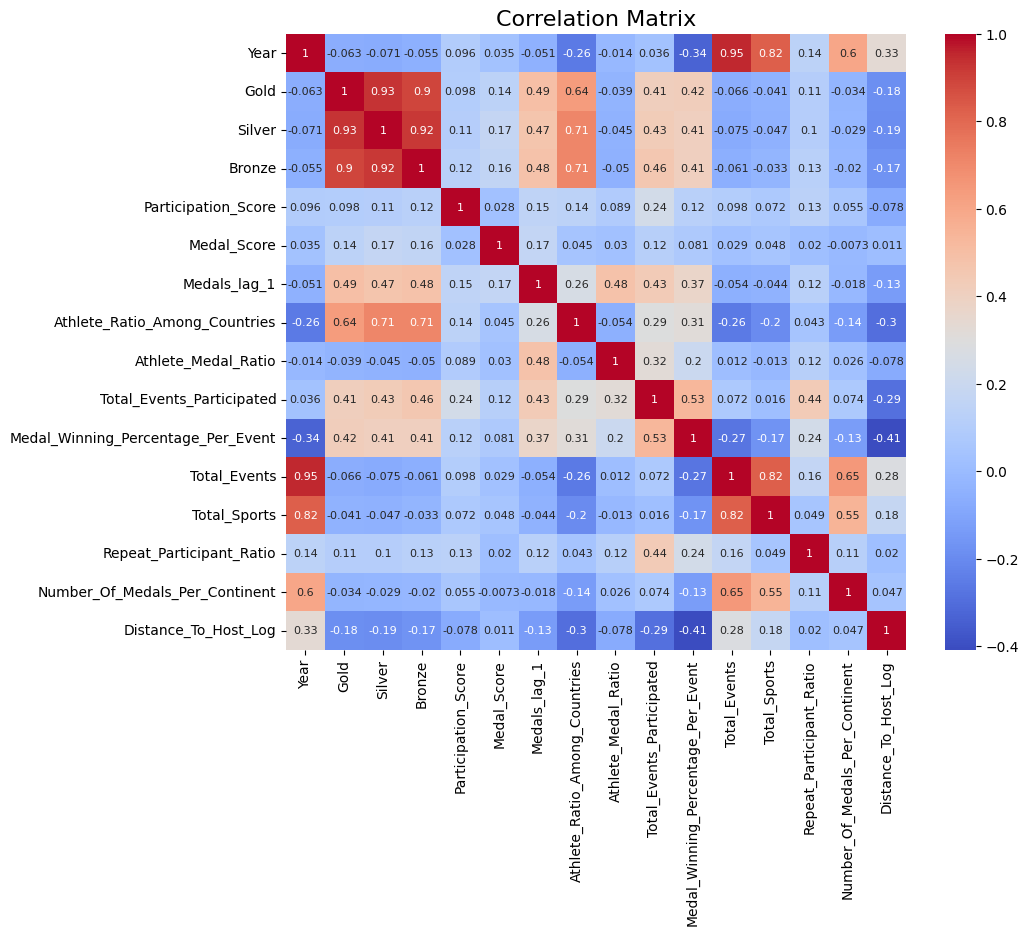

In [ ]:
correlation_matrix = final_df[numerical_features].corr()

# Trực quan hóa ma trận tương quan với heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})  # Giảm kích thước font chữ
plt.title('Correlation Matrix', fontsize=16)  # Tăng font chữ tiêu đề nếu cần
plt.show()

VIF

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu từ file
df= final_df[numerical_features]


# Kiểm tra lại xem còn giá trị NaN hoặc vô hạn không
if df.isna().sum().sum() > 0:
    print("Vẫn còn giá trị NaN trong dữ liệu!")
if np.isinf(df).sum().sum() > 0:
    print("Vẫn còn giá trị vô hạn trong dữ liệu!")

# Lọc các cột số (numerical columns)

# Chuẩn bị dữ liệu cho tính VIF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)  # Chuẩn hóa dữ liệu
print(X_scaled)
# Thêm hệ số chặn (constant) vào dữ liệu
X_scaled_with_const = add_constant(X_scaled)

# Tính VIF cho từng biến
vif = pd.DataFrame()
vif['Variable'] = ['const'] + df.columns.tolist()  # Thêm tên cột vào danh sách
vif['VIF'] = [variance_inflation_factor(X_scaled_with_const, i) for i in range(X_scaled_with_const.shape[1])]

# Hiển thị kết quả
print(vif)

# Lưu kết quả VIF vào file CSV
vif.to_csv('vif_results.csv', index=False)


[[-2.79937125  0.07829056 -0.32206906 ... -1.13986443 -1.99565568
   0.69048614]
 [-2.79937125 -0.2803276  -0.32206906 ... -1.13986443 -1.99565568
   0.69048614]
 [-2.79937125  0.07829056 -0.11509643 ...  0.05743491 -1.36236903
  -1.01789172]
 ...
 [ 1.19512331 -0.2803276  -0.32206906 ... -1.13986443  0.85413428
   0.07511488]
 [ 1.19512331 -0.2803276  -0.32206906 ... -1.13986443  1.29743494
   0.24916206]
 [ 1.19512331 -0.2803276  -0.32206906 ... -1.13986443  1.29743494
   0.30970857]]
                              Variable        VIF
0                                const   1.000000
1                                 Year  13.926819
2                                 Gold   8.558632
3                               Silver  11.613219
4                               Bronze   8.299220
5                  Participation_Score   1.097333
6                          Medal_Score   1.064769
7                         Medals_lag_1   2.141479
8        Athlete_Ratio_Among_Countries   2.624330
9       

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
X = final_df[categorical_features]  # Thay 'Target' bằng tên cột target thực tế
# Giả sử target là 'Gold', 'Silver', 'Bronze'
targets = ['Gold', 'Silver', 'Bronze']
results = []

# Tính Mutual Information cho từng cột target
for target in targets:
    mutual_info = mutual_info_classif(X, final_df[target], discrete_features=True)
    results.append(pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Info': mutual_info,
        'Target': target
    }))

# Kết hợp kết quả thành một DataFrame
mutual_info_df = pd.concat(results).sort_values(by=['Target', 'Mutual_Info'], ascending=[True, False])
print(mutual_info_df)


                   Feature  Mutual_Info  Target
3         Continent_Europe     0.051991  Bronze
4         Continent_Africa     0.027518  Bronze
0                  Is_Host     0.021093  Bronze
5  Continent_North America     0.011860  Bronze
1              Is_Neighbor     0.011543  Bronze
2           Continent_Asia     0.008267  Bronze
7  Continent_South America     0.005893  Bronze
6        Continent_Oceania     0.004755  Bronze
3         Continent_Europe     0.054281    Gold
0                  Is_Host     0.026388    Gold
4         Continent_Africa     0.023825    Gold
5  Continent_North America     0.015657    Gold
1              Is_Neighbor     0.012483    Gold
2           Continent_Asia     0.011109    Gold
7  Continent_South America     0.007077    Gold
6        Continent_Oceania     0.004202    Gold
3         Continent_Europe     0.057204  Silver
4         Continent_Africa     0.027582  Silver
0                  Is_Host     0.022753  Silver
5  Continent_North America     0.013775 

In [ ]:
print(final_df.columns)


Index(['Year', 'Gold', 'Silver', 'Bronze', 'Is_Host', 'Participation_Score',
       'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries',
       'Athlete_Medal_Ratio', 'Total_Events_Participated',
       'Medal_Winning_Percentage_Per_Event', 'Total_Events', 'Total_Sports',
       'Repeat_Participant_Ratio', 'Is_Neighbor',
       'Number_Of_Medals_Per_Continent', 'Distance_To_Host_Log',
       'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
       'Continent_North America', 'Continent_Oceania',
       'Continent_South America'],
      dtype='object')


In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Tách dữ liệu
X = final_df[['Year', 'Is_Host', 'Participation_Score',
              'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries',
              'Athlete_Medal_Ratio', 'Total_Events_Participated',
              'Medal_Winning_Percentage_Per_Event', 'Total_Events', 'Total_Sports',
              'Repeat_Participant_Ratio', 'Is_Neighbor',
              'Number_Of_Medals_Per_Continent', 'Distance_To_Host_Log',
              'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
              'Continent_North America', 'Continent_Oceania',
              'Continent_South America']]  # Đặc trưng

y = final_df[['Gold', 'Silver', 'Bronze']]  # Nhãn

# Chia tập dữ liệu thành Train và Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước của dữ liệu
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước X_test:", X_test.shape)
print("Kích thước y_test:", y_test.shape)

Kích thước X_train: (2966, 21)
Kích thước y_train: (2966, 3)
Kích thước X_test: (742, 21)
Kích thước y_test: (742, 3)


Thử nghiệm trên XGBoost

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Support Vector Regression": MultiOutputRegressor(SVR(kernel='rbf'))
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    # Append results
    results.append({
        "Model": name,
        "MSE_Gold": mse[0],
        "MSE_Silver": mse[1],
        "MSE_Bronze": mse[2],
        "RMSE_Gold": rmse[0],
        "RMSE_Silver": rmse[1],
        "RMSE_Bronze": rmse[2],
        "R2_Gold": r2[0],
        "R2_Silver": r2[1],
        "R2_Bronze": r2[2]
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.19253e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


                       Model   MSE_Gold  MSE_Silver  MSE_Bronze  RMSE_Gold  \
0          Linear Regression  11.008527    8.426970    6.946099   3.317910   
1           Ridge Regression  12.906385   10.455350    8.597088   3.592546   
2           Lasso Regression  11.914403    9.266153    7.562170   3.451725   
3              Random Forest   2.319397    2.351573    2.299838   1.522957   
4  Support Vector Regression  31.265765   23.795075   24.318075   5.591580   

   RMSE_Silver  RMSE_Bronze   R2_Gold  R2_Silver  R2_Bronze  
0     2.902924     2.635545  0.617204   0.609016   0.676900  
1     3.233473     2.932079  0.551210   0.514906   0.600104  
2     3.044036     2.749940  0.585704   0.570081   0.648244  
3     1.533484     1.516522  0.919348   0.890895   0.893022  
4     4.878020     4.931336 -0.087195  -0.104013  -0.131162  


In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
# Chuyển đổi Year thành số nguyên

# Khởi tạo mô hình XGBoost
xgb_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))

# Huấn luyện mô hình
xgb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred_xgb = xgb_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_xgb, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_xgb, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.71260695 0.73009125 0.76007459]
Mean Squared Error (MSE): [3.29449949 3.44679504 2.71982394]
Root Mean Squared Error (RMSE): [1.81507561 1.85655461 1.64918887]
R-squared (R²): [0.88544133 0.84008005 0.87348666]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới tham số
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV cho XGBoost
grid_search_xgb = GridSearchCV(
    MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Huấn luyện
grid_search_xgb.fit(X_train, y_train)

# Tham số tốt nhất
print("Best Parameters:", grid_search_xgb.best_params_)

# Mô hình tốt nhất
best_xgb_model = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
expected_feature_names = best_xgb_model.estimators_[0].get_booster().feature_names

# Ensure X_test has the same columns in the same order
X_test = X_test[expected_feature_names]
y_pred_xgb1 = best_xgb_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_xgb1, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_xgb1, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb1, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.69941919 0.71447297 0.75639968]
Mean Squared Error (MSE): [3.24442583 3.18678079 2.99999177]
Root Mean Squared Error (RMSE): [1.80122898 1.78515568 1.73204843]
R-squared (R²): [0.88718252 0.85214386 0.86045458]


In [ ]:
print(X_test)

      Year  Is_Host  Participation_Score  Medal_Score  Medals_lag_1  \
1783  1992        0             2.436417     2.424986             0   
1929  1996        0             2.309035     0.300000             0   
2916  2012        0             2.333285    16.747930            64   
787   1964        0             2.503239     3.828252             0   
798   1964        0             1.109035     0.300000             0   
...    ...      ...                  ...          ...           ...   
1954  1996        0             2.193963     3.889079            20   
596   1956        0             2.560479     4.714802             6   
3689  2024        0             2.487550    15.540320            38   
3020  2012        0             2.193963     0.303015             0   
296   1924        0             1.887550     0.300000             0   

      Athlete_Ratio_Among_Countries  Athlete_Medal_Ratio  \
1783                       0.002081             0.000000   
1929                       

In [ ]:
print("Columns in X_train:", list(X_train.columns))
print("Columns in X_test:", list(X_test.columns))


Columns in X_train: ['Year', 'Is_Host', 'Participation_Score', 'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries', 'Athlete_Medal_Ratio', 'Total_Events_Participated', 'Medal_Winning_Percentage_Per_Event', 'Total_Events', 'Total_Sports', 'Repeat_Participant_Ratio', 'Is_Neighbor', 'Number_Of_Medals_Per_Continent', 'Distance_To_Host_Log', 'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 'Continent_South America']
Columns in X_test: ['Year', 'Is_Host', 'Participation_Score', 'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries', 'Athlete_Medal_Ratio', 'Total_Events_Participated', 'Medal_Winning_Percentage_Per_Event', 'Total_Events', 'Total_Sports', 'Repeat_Participant_Ratio', 'Is_Neighbor', 'Number_Of_Medals_Per_Continent', 'Distance_To_Host_Log', 'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 'Continent_South America']


In [ ]:
import pandas as pd

# Danh sách để lưu tầm quan trọng của các feature từ từng mô hình con
feature_importances_list = []

# Lặp qua các mô hình con trong best_xgb_model
for i, estimator in enumerate(best_xgb_model.estimators_):
    feature_importances = estimator.feature_importances_  # Trích xuất feature_importances từ mô hình con
    feature_importances_list.append(pd.DataFrame({
        'Feature': X_train.columns,  # Tên các feature
        f'Importance_Target_{i}': feature_importances  # Tầm quan trọng cho từng target
    }))

# Gộp tất cả các tầm quan trọng vào một DataFrame
feature_importances_xgb = pd.concat(feature_importances_list, axis=1)

# Gộp các cột "Feature" lại duy nhất
feature_importances_xgb = feature_importances_xgb.loc[:, ~feature_importances_xgb.columns.duplicated()]

# Tính tầm quan trọng trung bình
feature_importances_xgb['Average_Importance'] = feature_importances_xgb.iloc[:, 1:].mean(axis=1)

# Sắp xếp theo tầm quan trọng trung bình
feature_importances_xgb = feature_importances_xgb.sort_values(by='Average_Importance', ascending=False)

# Xuất kết quả
print("Feature Importances Summary (kèm theo trung bình):")

# Nếu cần lưu ra file CSV
# feature_importances_df.to_csv('feature_importance_summary.csv', index=False)


Feature Importances Summary (kèm theo trung bình):


In [ ]:
# Danh sách các feature Continent_* cần giữ lại mặc định
continent_features = [
    'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
    'Continent_North America', 'Continent_Oceania', 'Continent_South America'
]

# Tính tầm quan trọng trung bình cho tất cả các nhãn (Gold, Silver, Bronze)

# Lựa chọn các feature dựa trên ngưỡng importance
threshold = 0.05
# Use bracket notation to access the 'Average_Importance' column
selected_features = feature_importances_xgb[feature_importances_xgb['Average_Importance'] >= threshold]['Feature'].tolist()

# Kết hợp với các feature Continent_* (đảm bảo luôn được chọn)
selected_features = list(set(selected_features + continent_features))

print("Các feature được chọn:")
print(selected_features)

Các feature được chọn:
['Continent_Asia', 'Total_Events_Participated', 'Continent_Africa', 'Continent_South America', 'Medal_Winning_Percentage_Per_Event', 'Continent_Europe', 'Is_Host', 'Continent_Oceania', 'Athlete_Ratio_Among_Countries', 'Continent_North America']


In [ ]:
# Huấn luyện mô hình Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred_rf = rf_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_rf, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_rf, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.63168464 0.65036388 0.68838275]
Mean Squared Error (MSE): [2.53796644 2.32962278 2.47776092]
Root Mean Squared Error (RMSE): [1.59309963 1.52631018 1.5740905 ]
R-squared (R²): [0.91174803 0.89191317 0.88474629]


In [ ]:
# Trích xuất độ quan trọng
rf_feature_importances = rf_model.feature_importances_

# Tạo DataFrame cho kết quả
rf_importances_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_feature_importances
}).sort_values(by="Importance", ascending=False)

print("Random Forest Feature Importances:")
print(rf_importances_df)

Random Forest Feature Importances:
                               Feature  Importance
5        Athlete_Ratio_Among_Countries    0.510473
8   Medal_Winning_Percentage_Per_Event    0.247213
7            Total_Events_Participated    0.091751
4                         Medals_lag_1    0.041273
3                          Medal_Score    0.025443
14                Distance_To_Host_Log    0.013269
10                        Total_Sports    0.011758
0                                 Year    0.011212
9                         Total_Events    0.010052
13      Number_Of_Medals_Per_Continent    0.008903
11            Repeat_Participant_Ratio    0.007317
2                  Participation_Score    0.007152
6                  Athlete_Medal_Ratio    0.007133
1                              Is_Host    0.002422
17                    Continent_Europe    0.002087
16                      Continent_Asia    0.000938
18             Continent_North America    0.000723
12                         Is_Neighbor    0.000

<Figure size 2000x600 with 0 Axes>

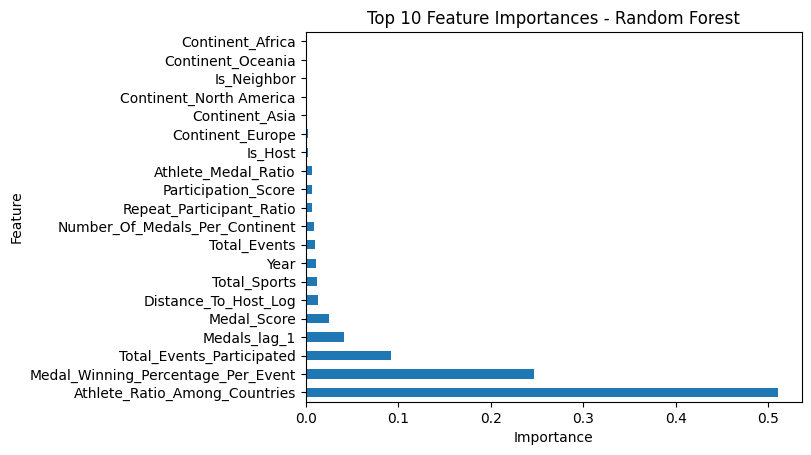

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(20, 6))
rf_importances_df.sort_values(by="Importance", ascending=False).head(20).plot(
    kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
# Danh sách các feature Continent_* cần giữ lại mặc định
continent_features = [
    'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
    'Continent_North America', 'Continent_Oceania', 'Continent_South America'
]

# Tính tầm quan trọng trung bình cho tất cả các nhãn (Gold, Silver, Bronze)

# Lựa chọn các feature dựa trên ngưỡng importance
threshold = 0.05
selected_features = rf_importances_df[rf_feature_importances >= threshold]['Feature'].tolist()

# Kết hợp với các feature Continent_* (đảm bảo luôn được chọn)
selected_features = list(set(selected_features + continent_features))

print("Các feature được chọn:")
print(selected_features)


Các feature được chọn:
['Total_Events', 'Continent_Asia', 'Continent_Africa', 'Continent_South America', 'Continent_Europe', 'Year', 'Continent_Oceania', 'Distance_To_Host_Log', 'Continent_North America']


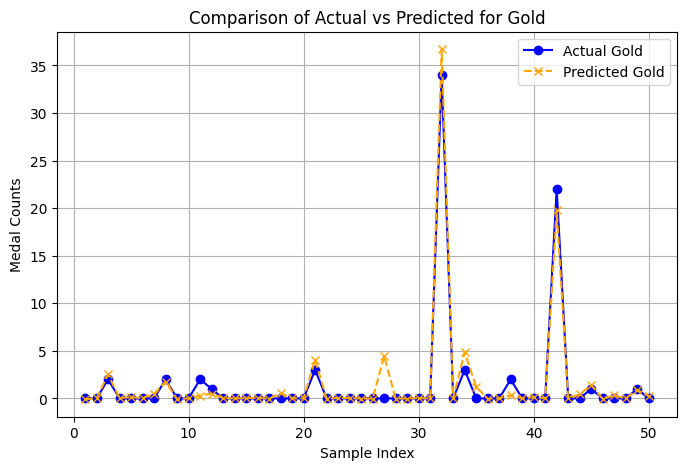

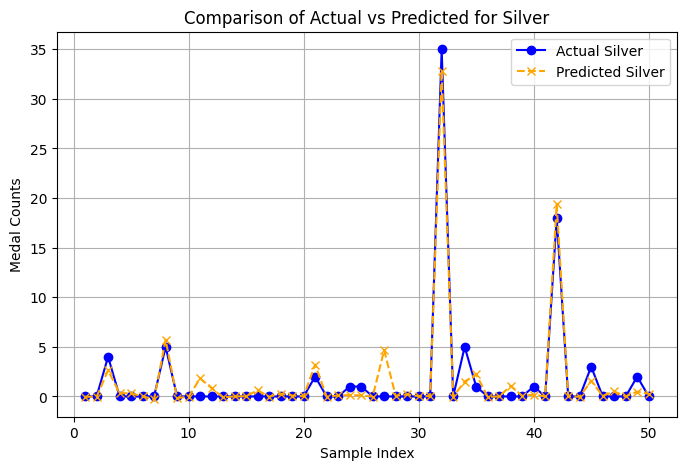

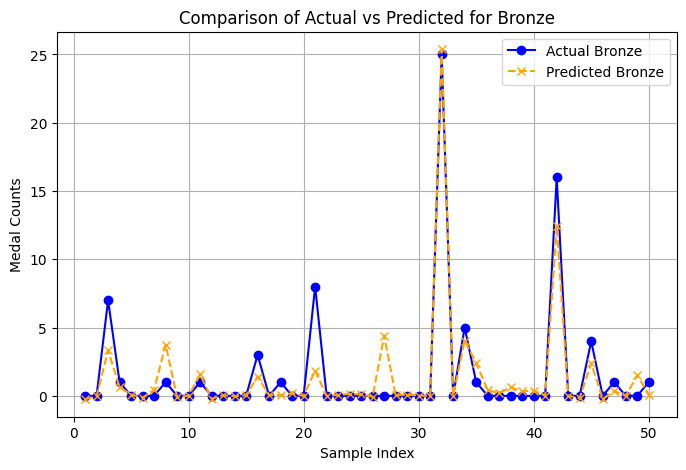

In [ ]:
import matplotlib.pyplot as plt
y_pred_rf = rf_model.predict(X_test)

# Chọn 10 mẫu đầu tiên từ tập kiểm tra để trực quan hóa
y_actual = y_test.iloc[:50].values  # Giá trị thực tế
y_pred = y_pred_xgb[:50]  # Giá trị dự đoán

# Tạo các biểu đồ đường riêng cho từng loại huy chương
categories = ['Gold', 'Silver', 'Bronze']
x = range(1, len(y_actual) + 1)  # Số thứ tự mẫu

for i, category in enumerate(categories):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y_actual[:, i], marker='o', label=f'Actual {category}', color='blue')
    plt.plot(x, y_pred[:, i], marker='x', linestyle='--', label=f'Predicted {category}', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Medal Counts')
    plt.title(f'Comparison of Actual vs Predicted for {category}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
y_pred_xgb =best_xgb_model.predict(X_test)
# Tính toán các chỉ số hiệu suất
metrics = {
    "Model": ["XGBoost"],
    "MSE_Gold": [mean_squared_error(y_test.iloc[:, 0], y_pred_xgb[:, 0])],
    "MSE_Silver": [mean_squared_error(y_test.iloc[:, 1], y_pred_xgb[:, 1])],
    "MSE_Bronze": [mean_squared_error(y_test.iloc[:, 2], y_pred_xgb[:, 2])],
    "RMSE_Gold": [np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred_xgb[:, 0]))],
    "RMSE_Silver": [np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred_xgb[:, 1]))],
    "RMSE_Bronze": [np.sqrt(mean_squared_error(y_test.iloc[:, 2], y_pred_xgb[:, 2]))],
    "MAE_Gold": [mean_absolute_error(y_test.iloc[:, 0], y_pred_xgb[:, 0])],
    "MAE_Silver": [mean_absolute_error(y_test.iloc[:, 1], y_pred_xgb[:, 1])],
    "MAE_Bronze": [mean_absolute_error(y_test.iloc[:, 2], y_pred_xgb[:, 2])],
    "R2_Gold": [r2_score(y_test.iloc[:, 0], y_pred_xgb[:, 0])],
    "R2_Silver": [r2_score(y_test.iloc[:, 1], y_pred_xgb[:, 1])],
    "R2_Bronze": [r2_score(y_test.iloc[:, 2], y_pred_xgb[:, 2])]
}

# Tạo DataFrame để hiển thị kết quả
performance_df = pd.DataFrame(metrics)
print(performance_df)
# Hiển thị bảng kết quả

     Model  MSE_Gold  MSE_Silver  MSE_Bronze  RMSE_Gold  RMSE_Silver  \
0  XGBoost  3.244426    3.186781    2.999992   1.801229     1.785156   

   RMSE_Bronze  MAE_Gold  MAE_Silver  MAE_Bronze   R2_Gold  R2_Silver  \
0     1.732048  0.699419    0.714473      0.7564  0.887183   0.852144   

   R2_Bronze  
0   0.860455  


In [ ]:
y_pred_rf = rf_model.predict(X_test)

# Tính toán các chỉ số hiệu suất cho Random Forest
rf_metrics = {
    "Model": ["Random Forest"],
    "MSE_Gold": [mean_squared_error(y_test.iloc[:, 0], y_pred_rf[:, 0])],
    "MSE_Silver": [mean_squared_error(y_test.iloc[:, 1], y_pred_rf[:, 1])],
    "MSE_Bronze": [mean_squared_error(y_test.iloc[:, 2], y_pred_rf[:, 2])],
    "RMSE_Gold": [np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred_rf[:, 0]))],
    "RMSE_Silver": [np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred_rf[:, 1]))],
    "RMSE_Bronze": [np.sqrt(mean_squared_error(y_test.iloc[:, 2], y_pred_rf[:, 2]))],
    "MAE_Gold": [mean_absolute_error(y_test.iloc[:, 0], y_pred_rf[:, 0])],
    "MAE_Silver": [mean_absolute_error(y_test.iloc[:, 1], y_pred_rf[:, 1])],
    "MAE_Bronze": [mean_absolute_error(y_test.iloc[:, 2], y_pred_rf[:, 2])],
    "R2_Gold": [r2_score(y_test.iloc[:, 0], y_pred_rf[:, 0])],
    "R2_Silver": [r2_score(y_test.iloc[:, 1], y_pred_rf[:, 1])],
    "R2_Bronze": [r2_score(y_test.iloc[:, 2], y_pred_rf[:, 2])]
}

# Kết hợp kết quả của cả XGBoost và Random Forest
combined_metrics_df = pd.concat(
    [performance_df, pd.DataFrame(rf_metrics)],
    ignore_index=True
)
print(combined_metrics_df)

           Model  MSE_Gold  MSE_Silver  MSE_Bronze  RMSE_Gold  RMSE_Silver  \
0        XGBoost  3.244426    3.186781    2.999992   1.801229     1.785156   
1  Random Forest  2.537966    2.329623    2.477761   1.593100     1.526310   

   RMSE_Bronze  MAE_Gold  MAE_Silver  MAE_Bronze   R2_Gold  R2_Silver  \
0     1.732048  0.699419    0.714473    0.756400  0.887183   0.852144   
1     1.574091  0.631685    0.650364    0.688383  0.911748   0.891913   

   R2_Bronze  
0   0.860455  
1   0.884746  


So sánh tổng quan
Random Forest hoạt động tốt hơn XGBoost trên tất cả các nhãn.
MSE và RMSE thấp hơn: Random Forest có sai số dự đoán thấp hơn so với XGBoost cho cả 3 nhãn.
MAE thấp hơn: Random Forest cho thấy dự đoán gần giá trị thực tế hơn trên từng nhãn.
R² cao hơn: Random Forest có khả năng giải thích phương sai dữ liệu tốt hơn.
2. Phân tích chi tiết từng chỉ số
a. MSE (Mean Squared Error):
Random Forest có MSE thấp hơn XGBoost:
Gold: 2.535 (RF) so với 3.244 (XGB).
Silver: 2.333 (RF) so với 3.187 (XGB).
Bronze: 2.499 (RF) so với 3.000 (XGB).
Ý nghĩa: Sai số bình phương trung bình của Random Forest nhỏ hơn, cho thấy dự đoán của Random Forest chính xác hơn.
b. RMSE (Root Mean Squared Error):
Random Forest cũng có RMSE thấp hơn trên cả 3 nhãn:
Gold: 1.592 (RF) < 1.801 (XGB).
Silver: 1.528 (RF) < 1.785 (XGB).
Bronze: 1.581 (RF) < 1.732 (XGB).
Ý nghĩa: Sai số dự đoán của Random Forest thấp hơn XGBoost khi so sánh giá trị trung bình bình phương gốc.
c. MAE (Mean Absolute Error):
Random Forest tiếp tục thể hiện tốt hơn XGBoost:
Gold: 0.632 (RF) < 0.699 (XGB).
Silver: 0.650 (RF) < 0.714 (XGB).
Bronze: 0.690 (RF) < 0.756 (XGB).
Ý nghĩa: Random Forest dự đoán gần hơn với giá trị thực tế so với XGBoost.
d. R² Score (Hệ số xác định):
Random Forest có R² cao hơn, đặc biệt:
Gold: 0.912 (RF) > 0.887 (XGB).
Silver: 0.892 (RF) > 0.852 (XGB).
Bronze: 0.884 (RF) > 0.860 (XGB).

# Thử nghiệm trên LightGBM

In [ ]:
from lightgbm import LGBMRegressor

# Khởi tạo mô hình LightGBM
lgb_model = MultiOutputRegressor(LGBMRegressor(random_state=42))

# Huấn luyện mô hình
lgb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test)

# Đánh giá hiệu suất
mse_lgb = mean_squared_error(y_test, y_pred_lgb, multioutput='raw_values')
print("LightGBM - Mean Squared Error (MSE):", mse_lgb)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 21
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 21
[LightGBM] [Info] Start training from score 1.545853
[LightGBM] [Warning] Found whi

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

# Định nghĩa lưới tham số
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

# Khởi tạo mô hình LightGBM với MultiOutputRegressor
lgb_model = MultiOutputRegressor(LGBMRegressor(random_state=42))

# Tạo GridSearchCV
grid_search_lgb = GridSearchCV(
    lgb_model,  # Pass the MultiOutputRegressor instance
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Huấn luyện - y_train should be a DataFrame with multiple columns
grid_search_lgb.fit(X_train, y_train)

# Tham số tốt nhất
print("Best Parameters:", grid_search_lgb.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 21
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
best_params = grid_search_lgb.best_params_
print("Best Parameters:", best_params)

# Huấn luyện lại mô hình trên toàn bộ tập train với tham số tốt nhất
best_lgb_model = MultiOutputRegressor(LGBMRegressor(**best_params, random_state=42))
best_lgb_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_lgb = best_lgb_model.predict(X_test)

# Đánh giá hiệu suất
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_lgb, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred_lgb, multioutput="raw_values")
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgb, multioutput="raw_values")

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Best Parameters: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__subsample': 0.8}
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred_lgb = best_lgb_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_lgb, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_lgb, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgb, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__subsample
Mean Absolute Error (MAE): [0.70667257 0.69

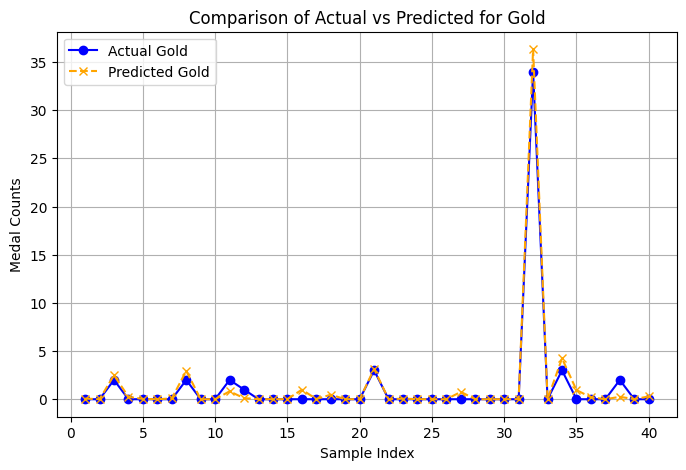

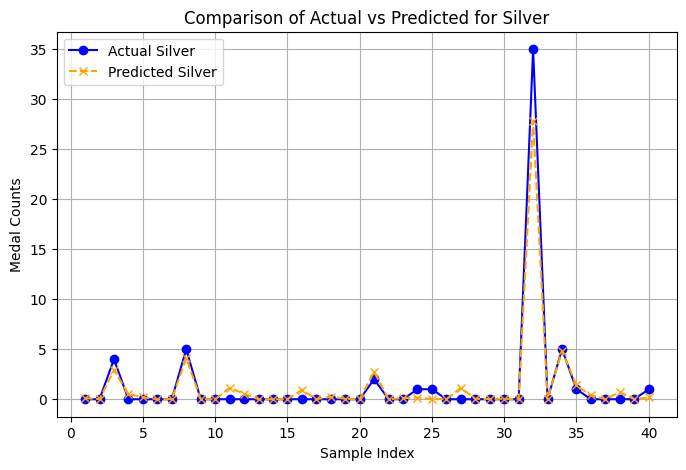

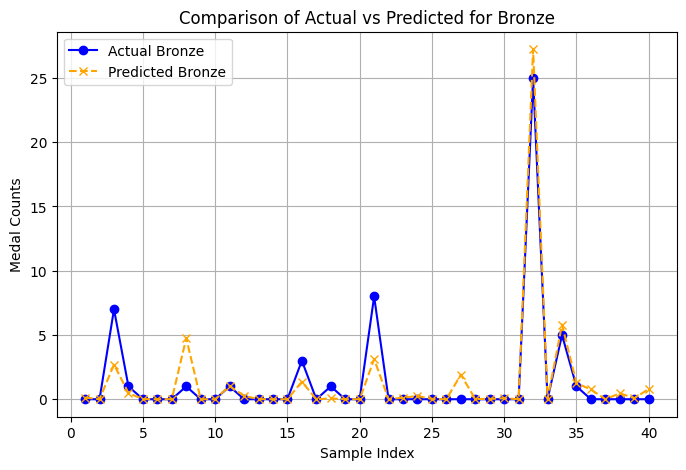

In [ ]:
import matplotlib.pyplot as plt

# Chọn 10 mẫu đầu tiên từ tập kiểm tra để trực quan hóa
y_actual = y_test.iloc[:40].values  # Giá trị thực tế
y_pred = y_pred_rf[:40]  # Giá trị dự đoán

# Tạo các biểu đồ đường riêng cho từng loại huy chương
categories = ['Gold', 'Silver', 'Bronze']
x = range(1, len(y_actual) + 1)  # Số thứ tự mẫu

for i, category in enumerate(categories):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y_actual[:, i], marker='o', label=f'Actual {category}', color='blue')
    plt.plot(x, y_pred[:, i], marker='x', linestyle='--', label=f'Predicted {category}', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Medal Counts')
    plt.title(f'Comparison of Actual vs Predicted for {category}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# Khởi tạo và bọc MultiOutputRegressor
model = MultiOutputRegressor(lgb.LGBMRegressor())
model.fit(X_train, y_train)

# Lấy feature importances cho từng đầu ra
for i, estimator in enumerate(model.estimators_):
    print(f"Feature importances for output {i}:")
    print(estimator.feature_importances_)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 21
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 21
[LightGBM] [Info] Start training from score 1.545853
[LightGBM] [Warning] Found whi

In [ ]:
import numpy as np

# Tính trung bình tầm quan trọng đặc trưng trên các đầu ra
feature_importances = np.mean([estimator.feature_importances_ for estimator in model.estimators_], axis=0)

# Hiển thị kết quả
features = X.columns if hasattr(X, 'columns') else range(len(feature_importances))
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                               Feature  Importance
5        Athlete_Ratio_Among_Countries  697.333333
8   Medal_Winning_Percentage_Per_Event  473.666667
3                          Medal_Score  280.666667
7            Total_Events_Participated  264.000000
4                         Medals_lag_1  256.000000
14                Distance_To_Host_Log  232.000000
11            Repeat_Participant_Ratio  164.666667
2                  Participation_Score  138.666667
0                                 Year  132.333333
6                  Athlete_Medal_Ratio  129.666667
13      Number_Of_Medals_Per_Continent   97.333333
10                        Total_Sports   39.666667
9                         Total_Events   36.000000
1                              Is_Host   27.000000
17                    Continent_Europe   11.333333
12                         Is_Neighbor   10.000000
16                      Continent_Asia    7.333333
19                   Continent_Oceania    1.333333
18             Continent_North 

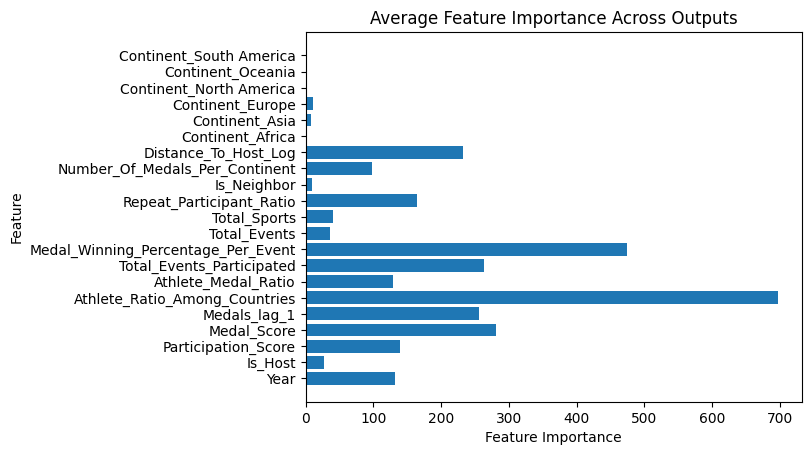

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Outputs')
plt.show()


In [ ]:
# Danh sách các feature Continent_* cần giữ lại mặc định
continent_features = [
    'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
    'Continent_North America', 'Continent_Oceania', 'Continent_South America'
]

# Tính tầm quan trọng trung bình cho tất cả các nhãn (Gold, Silver, Bronze)

# Lựa chọn các feature dựa trên ngưỡng importance
threshold = 5
selected_features = importance_df[feature_importances >= threshold]['Feature'].tolist()

# Kết hợp với các feature Continent_* (đảm bảo luôn được chọn)
selected_features = list(set(selected_features + continent_features))

print("Các feature được chọn:")
print(selected_features)


Các feature được chọn:
['Continent_Asia', 'Total_Events_Participated', 'Continent_Africa', 'Continent_South America', 'Medal_Winning_Percentage_Per_Event', 'Continent_Europe', 'Year', 'Is_Host', 'Continent_Oceania', 'Distance_To_Host_Log', 'Repeat_Participant_Ratio', 'Participation_Score', 'Total_Sports', 'Number_Of_Medals_Per_Continent', 'Athlete_Medal_Ratio', 'Athlete_Ratio_Among_Countries', 'Continent_North America', 'Total_Events', 'Medal_Score', 'Medals_lag_1']


In [ ]:
# Danh sách các feature từ từng mô hình
lightgbm_features = ['Continent_Asia', 'Total_Events_Participated', 'Continent_Africa', 'Continent_South America', 'Medal_Winning_Percentage_Per_Event', 'Continent_Europe', 'Year', 'Is_Host', 'Continent_Oceania', 'Distance_To_Host_Log', 'Repeat_Participant_Ratio', 'Participation_Score', 'Total_Sports', 'Number_Of_Medals_Per_Continent', 'Athlete_Medal_Ratio', 'Athlete_Ratio_Among_Countries', 'Continent_North America', 'Total_Events', 'Medal_Score', 'Medals_lag_1']


random_features = [
    'Distance_To_Host_Log', 'Continent_Asia', 'Total_Sports',
    'Continent_South America', 'Continent_North America', 'Total_Events',
    'Continent_Africa', 'Continent_Oceania', 'Continent_Europe'
]

xgboost_features = [
    'Continent_Africa', 'Participation_Score', 'Is_Neighbor', 'Medal_Score',
    'Distance_To_Host_Log', 'Total_Sports', 'Continent_North America',
    'Athlete_Medal_Ratio', 'Number_Of_Medals_Per_Continent', 'Total_Events',
    'Continent_South America', 'Repeat_Participant_Ratio',
    'Total_Events_Participated', 'Continent_Oceania', 'Is_Host',
    'Medals_lag_1', 'Continent_Europe', 'Medal_Winning_Percentage_Per_Event',
    'Continent_Asia', 'Year', 'Athlete_Ratio_Among_Countries'
]

# Tổng hợp danh sách và loại bỏ trùng lặp
all_features = list(dict.fromkeys(lightgbm_features + random_features + xgboost_features))



<built-in method count of list object at 0x79fe7d22e780>


In [ ]:
# Chọn feature và nhãn
X = final_df[lightgbm_features]
y = final_df[['Gold', 'Silver', 'Bronze']].values  # Đảm bảo y là mảng 2D

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (2966, 9)
Shape of y_train: (2966, 3)
Shape of X_test: (742, 9)
Shape of y_test: (742, 3)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# Khởi tạo các mô hình base
lgb_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)



# Chia dữ liệu train/test
# Chọn feature và nhãn
X = final_df[lightgbm_features]
y = final_df[['Gold', 'Silver', 'Bronze']].values  # Đảm bảo y là mảng 2D

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Tạo các mô hình thành phần
estimators = [
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model),
    ('random_forest', rf_model)
]

# Mô hình meta
meta_model = Ridge()

# Tạo Stacking Regressor với Multi-Output
stacking_model = MultiOutputRegressor(
    StackingRegressor(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5  # Cross-validation
    )
)

# Huấn luyện
stacking_model.fit(X_train, y_train)

# Dự đoán
stacking_pred = stacking_model.predict(X_test)

# Đánh giá từng đầu ra (Gold, Silver, Bronze)
mse_gold = mean_squared_error(y_test[:, 0], stacking_pred[:, 0])
mse_silver = mean_squared_error(y_test[:, 1], stacking_pred[:, 1])
mse_bronze = mean_squared_error(y_test[:, 2], stacking_pred[:, 2])

# In kết quả
print(f"Mean Squared Error (Gold): {mse_gold}")
print(f"Mean Squared Error (Silver): {mse_silver}")
print(f"Mean Squared Error (Bronze): {mse_bronze}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 21
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 2372, number of used features: 20
[LightGBM] [Info] Start training from score 1.525295
[LightGBM] [Warning] Found whi

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Tính các chỉ số
mae = mean_absolute_error(y_test, stacking_pred, multioutput='raw_values')
mse = mean_squared_error(y_test, stacking_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, stacking_pred, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.67290559 0.70038182 0.72174541]
Mean Squared Error (MSE): [2.43778197 2.71729658 2.4292931 ]
Root Mean Squared Error (RMSE): [1.5613398  1.64842245 1.55861897]
R-squared (R²): [0.91523171 0.87392638 0.88700078]


In [ ]:
import numpy as np

# Sử dụng đầu ra từ stacking_model
y_pred_stacking = stacking_model.predict(X_train)

# Chuẩn bị dữ liệu đầu vào cho LSTM
# Kết hợp dữ liệu gốc với dữ liệu dự đoán từ stacking_model
lstm_input_data = np.hstack([X_train['Year'].values.reshape(-1, 1), y_pred_stacking])

# Xếp lại thứ tự theo năm
lstm_input_data = lstm_input_data[np.argsort(lstm_input_data[:, 0])]

# Xây dựng dữ liệu với các bước thời gian
def create_lstm_data(data, lookback=5):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 1:])  # Bỏ cột năm, chỉ lấy đầu ra
        y.append(data[i, 1:])  # Dự đoán Gold, Silver, Bronze
    return np.array(X), np.array(y)

lookback = 5  # Sử dụng dữ liệu của 5 năm trước để dự đoán
X_lstm, y_lstm = create_lstm_data(lstm_input_data)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Xây dựng mô hình LSTM
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(lookback, y_lstm.shape[1])),
    Dense(32, activation='relu'),
    Dense(y_lstm.shape[1])  # Đầu ra tương ứng với Gold, Silver, Bronze
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

# Huấn luyện mô hình
model_lstm.fit(X_lstm, y_lstm, epochs=50, batch_size=16, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,587 (76.51 KB)

 Trainable params: 19,587 (76.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 31.7012
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 27.0444
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32.0119
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 28.3914
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.7359
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.4958
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.5815
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.5796
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21.7318
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.5729
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.7283
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25.7995
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.7912
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25.4178
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
# Lấy dữ liệu của 5 năm gần nhất từ dữ liệu đầu vào
last_5_years = lstm_input_data[-lookback:, 1:]

# Dự đoán năm 2028
y_pred_2028 = model_lstm.predict(last_5_years[np.newaxis, :, :])

print("Dự đoán cho năm 2028 (Gold, Silver, Bronze):", y_pred_2028.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Dự đoán cho năm 2028 (Gold, Silver, Bronze): [3.410882  2.810493  3.4431763]
